In [2]:
import matplotlib.pyplot as plt
import gen from SRGAN
import os

In [6]:
import numpy as np
import cv2

# Match contours to license plate or character template
def find_contours(dimensions, img):

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or 15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    # Read the binary image
    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    
    # Read all contours detected
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            
            # stores the x coordinate of the character's contour, to used later for indexing the contours
            x_cntr_list.append(intX)
            char_copy = np.zeros((44,24))
            
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            # Draw rectangle around contour
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            
            # Display the uptated binary image with new contour
            plt.imshow(ii, cmap='gray')
            
            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)
            
            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0
            
            # List that stores the character's binary image (unsorted)
            img_res.append(char_copy) 
            
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    
    for idx in indices:
        # stores character images according to their index
        img_res_copy.append(img_res[idx])
        
    img_res = np.array(img_res_copy)
   
    return img_res

In [12]:
# Find characters in the resulting images and Preprocess license plate image
def segment_characters(image):
    # Resizing
    img_lp = cv2.resize(image, (333, 75))
    
    # Apply gray scale
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    
    # Convert to binary image
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Erode unwanted pixels
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    
    # Dilate unwanted pixels
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))
    
    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]
    
    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255
    
    # Estimations of character contours sizes of cropped license plates
    dimensions = [(LP_WIDTH/6) + 12.5, (LP_WIDTH/2) + 7.5, (LP_HEIGHT/10) - 15, 2 * LP_HEIGHT/3]
    
    # Visual display of binary image
#     plt.imshow(img_binary_lp, cmap='gray')
#     plt.show()
    
    # Create a binary image for next steps
#     cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

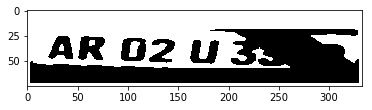

5


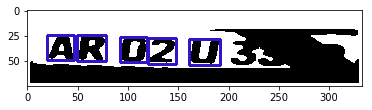

In [9]:
# img=cv2.resize(cv2.imread('AR02U3382.png'),(256,256))
img = cv2.GaussianBlur(cv2.resize(cv2.imread('AR02U3382.png'),(256,256)),(5,5),0.8)
# cv2.imshow("img",img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
cv2.imwrite("super_res2.png",img)
char = segment_characters(img)
print(len(char))

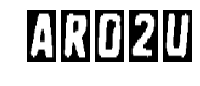

In [25]:
for i in range(len(char)):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [7]:
import tensorflow as tf
tf.enable_eager_execution()

AttributeError: module 'tensorflow' has no attribute 'enable_eager_execution'

In [ ]:
# import os
# path='data/train'
# ch_list=path
# for ch in os.listdir(ch_list):
# #     print((os.path.join(ch_list,ch)))
# #     print(os.path.join(ch_list,ch))
# #     print(os.listdir(ch_list))

#     for img in os.listdir(os.path.join(ch_list,ch)):
#         img_lr= cv2.GaussianBlur(cv2.imread(os.path.join(os.path.join(ch_list,ch),img)),(5,5),0)
#         new_path=os.path.join('data/train_low',ch)
#         cv2.imwrite('result.jpg', img_lr)
# print(.)
# # path='data/validation'
# # img_list= os.listdir(path)
# # for img in img_list:
# #     img_lr= cv2.GaussianBlur(cv2.imread(os.path.join(path,img)),(5,5),0)
# #     cv2.imwrite('data/validation_low/'+img, img_lr)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)

# Load training data
train_generator = train_datagen.flow_from_directory('data/train', target_size=(28,28), batch_size=1, class_mode='categorical')

# Load validation data
validation_generator = train_datagen.flow_from_directory('data/validation', target_size=(28,28), batch_size=1, class_mode='categorical')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers

In [12]:
# CNN model
model = Sequential()
model.add(Conv2D(32, (5,5), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])

In [13]:
# training the model
batch_size = 1
model.fit_generator(train_generator, validation_data = validation_generator, epochs = 30)

C:\Users\Dell\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
864/864 [==============================] - 6s 7ms/step - loss: 3.5716 - accuracy: 0.0291 - val_loss: 3.4728 - val_accuracy: 0.0648
Epoch 2/30
864/864 [==============================] - 6s 7ms/step - loss: 3.4279 - accuracy: 0.0784 - val_loss: 3.2866 - val_accuracy: 0.2361
Epoch 3/30
864/864 [==============================] - 6s 7ms/step - loss: 3.2549 - accuracy: 0.1578 - val_loss: 3.0103 - val_accuracy: 0.4074
Epoch 4/30
864/864 [==============================] - 6s 7ms/step - loss: 2.9716 - accuracy: 0.2695 - val_loss: 2.6081 - val_accuracy: 0.5000
Epoch 5/30
864/864 [==============================] - 6s 7ms/step - loss: 2.5462 - accuracy: 0.4258 - val_loss: 2.2094 - val_accuracy: 0.5787
Epoch 6/30
864/864 [==============================] - 6s 7ms/step - loss: 2.1021 - accuracy: 0.5004 - val_loss: 1.8090 - val_accuracy: 0.7083
Epoch 7/30
864/864 [==============================] - 5s 6ms/step - loss: 1.7234 - accuracy: 0.6432 - val_loss: 1.5303 - val_accuracy: 0.7130
Epoch 

In [33]:
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img

# Predicting the character/number from contours using trained model
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c
    output = []
    for i,ch in enumerate(char): # iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) # preparing image for the model
        y_ = model.predict_classes(img)[0] # predicting the class
        character = dic[y_] # get the predicted character
        output.append(character) # storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print("Predicted character/numbers = ", show_results())

Predicted character/numbers =  V


In [4]:
num_plate_data_path="generated"
state_wise_list=os.listdir(num_plate_data_path)
images_path_list=[]
for state in state_wise_list:
    state_path=os.path.join(num_plate_data_path,state)
    category_wise_list=os.listdir(state_path)
    for category in category_wise_list:
        category_path=os.path.join(state_path,category)
        images_category_wise=os.listdir(category_path)
        for image_num_plate in images_category_wise:
            images_path_list.append(os.path.join(category_path,image_num_plate))

In [ ]:
accuracy_lr=0
accuracy_sr=0

sr 0
sr 6
sr 0
sr 2
sr 0
sr 0
sr 0
sr 0
sr 4
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 4
sr 0
sr 0
sr 9
sr 0
sr 2
sr 0
sr 0
sr 0
sr 0
sr 1
sr 0
sr 0
sr 3
sr 9
sr 1
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 5
sr 0
sr 0
sr 0
sr 0
sr 0
sr 1
sr 4
sr 0
sr 0
sr 0
sr 1
sr 0
sr 0
sr 1
sr 0
sr 9
sr 0
sr 0
sr 0
sr 0
sr 0
sr 4
sr 0
sr 0
sr 0
sr 1
sr 1
sr 0
sr 0
sr 1
sr 4
sr 1
sr 0
sr 0
sr 0
sr 0
sr 2
sr 6
sr 1
sr 2
sr 0
sr 6
sr 0
sr 0
sr 0
sr 0
sr 0
sr 1
sr 0
sr 0
sr 10
sr 0
sr 0
sr 4
sr 1
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 4
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 1
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 4
sr 0
sr 0
sr 0
sr 0
sr 0
sr 2
sr 1
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 3
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0
sr 2
sr 0
sr 0
sr 0
sr 0
sr 0
sr 0

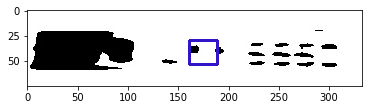

In [32]:
for (i,img_path) in enumerate(images_path_list):
    if i==500:
        break
    lr_img = cv2.GaussianBlur(cv2.resize(cv2.imread(img_path),(64,64)),(5,5),0.8)
    char = segment_characters(lr_img)
    sr_img = cv2.resize(cv2.imread(img_path),(256,256))
    char = gen(segment_characters(sr_img))



In [36]:
print("Character Identification Accuracy for LR images:", accuracy_lr*100/(500*9),)
print("Character Identification Accuracy for HR images:", accuracy_sr*100/(500*9) )

Character Identification Accuracy for LR images: 23.955555555555556
Character Identification Accuracy for HR images: 62.22222222222222
